# Overview

# Business Problem

Gas prices directly affect drivers everywhere. The rise of gas prices will financially impact their decisions and budgetary allowances, possibly restricting travel opportunities. With the ability to estimate future pricing, this could give individuals as well as transportation companies information so that they can plan ahead and account for any rise or decline.

# Data Understanding

Our data was combined and collected from multiple sources including the EIA Open Data API, Fred Economic Data, and Matteo Iacovello's Geopolitical Risk Index dataset. Our target variable is a retail gas prices in US dollars. 

In [50]:
#importing necessary libraries
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 400)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima  

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading in the data
oil_prices = pd.read_csv('Data/OilPrices.csv')

#checking the rows & columns of the data
oil_prices.shape

(578, 32)

In [3]:
#checking the first 5 rows
oil_prices.head()

,date,retail_gas_price,regular_gas_price,premium_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_TURKEY,GPR_MEXICO,GPR_KOREA,GPR_RUSSIA,GPR_INDIA,GPR_BRAZIL,GPR_CHINA,GPR_INDONESIA,GPR_SAUDI_ARABIA,GPR_SOUTH_AFRICA,GPR_ARGENTINA,GPR_COLOMBIA,GPR_VENEZUELA,GPR_THAILAND,GPR_UKRAINE,GPR_ISRAEL,GPR_MALAYSIA,GPR_PHILIPPINES,GPR_HONG_KONG
0,1973-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8981.323,136.3,6.256,4.124,8.275,6.17776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9178.750,136.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1973-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9098.194,136.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9095.200,135.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9062.548,135.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#checking the dtypes
oil_prices.dtypes.head()

date                  object
retail_gas_price     float64
regular_gas_price    float64
premium_gas_price    float64
europe_brent         float64
dtype: object

In [5]:
oil_prices.describe()

,retail_gas_price,regular_gas_price,premium_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_TURKEY,GPR_MEXICO,GPR_KOREA,GPR_RUSSIA,GPR_INDIA,GPR_BRAZIL,GPR_CHINA,GPR_INDONESIA,GPR_SAUDI_ARABIA,GPR_SOUTH_AFRICA,GPR_ARGENTINA,GPR_COLOMBIA,GPR_VENEZUELA,GPR_THAILAND,GPR_UKRAINE,GPR_ISRAEL,GPR_MALAYSIA,GPR_PHILIPPINES,GPR_HONG_KONG
count,518.000000,364.000000,315.000000,406.000000,422.000000,481.000000,578.000000,578.000000,48.000000,47.000000,44.000000,47.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1.831703,2.070173,2.517546,46.446305,44.090735,12243.977131,6510.779481,170.615052,9.161771,16.432085,24.586727,3.967960,111.459363,99.425612,108.552444,106.157076,93.797929,104.037631,106.273965,73.921822,92.811139,111.246845,111.025338,79.264288,85.936609,94.582728,128.577031,84.094340,89.687374,98.772223,103.192628
std,0.882518,0.879257,0.910967,32.212641,28.735599,6901.931759,1863.189391,38.610005,2.463364,8.543650,11.859635,2.976733,43.204881,25.863020,38.467790,28.932982,27.779754,29.848090,30.028329,31.879336,33.168800,46.124477,43.701844,28.850587,38.497569,38.837927,64.432099,22.828057,35.027091,35.202383,43.609107
min,0.629000,0.921000,1.112000,9.820000,11.350000,-6454.000000,3292.526000,118.400000,5.051000,3.953000,8.132000,-0.355546,32.630966,55.027180,38.703595,47.675739,48.592841,43.022946,56.530560,20.195272,33.177399,36.626554,36.401680,22.781653,16.383513,35.438023,22.178185,45.782138,17.493473,35.246466,41.055417
25%,1.185250,1.199750,1.614500,18.792500,19.815000,7296.000000,4947.443750,141.550000,7.379750,8.891000,12.582500,2.159069,82.172208,80.657549,83.110333,86.107217,77.231851,84.635982,86.758396,51.272778,67.041119,78.380801,81.591078,58.411975,58.712477,68.791618,81.055858,67.727024,66.931549,72.830272,75.984658
50%,1.353500,2.043500,2.685000,32.920000,31.975000,11650.000000,6075.096500,161.250000,9.068500,19.647000,25.431000,3.028820,102.466897,93.516162,101.524757,100.772778,86.619624,100.435857,98.512790,67.993152,87.333268,100.337905,103.911472,76.751229,81.787949,86.356645,110.670476,80.124521,83.607677,92.147624,94.100410
75%,2.510500,2.730500,3.204500,65.845000,62.252500,16434.000000,7606.091000,192.600000,10.998000,23.734000,35.427500,4.563769,133.026432,112.810135,124.774410,118.516517,103.252657,117.011294,121.004825,89.466255,113.352947,137.424993,132.767482,95.960363,107.301771,109.548548,170.865361,94.399759,105.816729,120.120184,114.671167
max,4.142000,4.062000,4.298000,132.720000,133.880000,33290.000000,12375.669000,267.000000,13.714000,26.741000,43.845000,13.549202,320.257923,215.507676,274.424333,241.381421,246.561895,221.406770,253.398709,275.937988,210.636587,301.707870,371.011584,171.849735,233.484231,296.192780,382.865514,179.204698,278.881456,215.536887,373.784359


# Data Preparation

In [6]:
#changing the date column to datetime and setting it as the index
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
oil_prices.set_index('date', inplace = True)

The data has 31 columns now that we have set the datetime index. Employees and import data go all the way back to 1973. The other columns start to appear around 1995. We will make '95 our starting point and go all the way until 2020.

In [7]:
oil_prices = oil_prices.loc['1995-01':'2020-12']

For the GPR data that we collected, we decided to filter it and keep ONLY the countries that are in top 5 sources of US oil & petroleum imports according to the eia:

https://www.eia.gov/energyexplained/oil-and-petroleum-products/imports-and-exports.php#:~:text=Of%20the%2013%20members%20of,and%20the%20United%20Arab%20Emirates

In [8]:
#removing unnecessary columns
columns_to_remove = ['GPR_TURKEY', 'GPR_KOREA', 'GPR_INDIA', 'GPR_BRAZIL', 'GPR_CHINA', 'GPR_INDONESIA', 
                     'GPR_SOUTH_AFRICA', 'GPR_ARGENTINA', 'GPR_VENEZUELA', 'GPR_THAILAND', 'GPR_UKRAINE', 
                     'GPR_ISRAEL', 'GPR_MALAYSIA', 'GPR_PHILIPPINES', 'GPR_HONG_KONG']

for i in columns_to_remove:
    del oil_prices[i]

In [37]:
#checking out the new DataFrame
oil_prices.tail()

,retail_gas_price,regular_gas_price,premium_gas_price,europe_brent,wti,oil_supply,crude_oil_production,employees_oil_extraction,imports,federal_gas_tax,state_gas_tax,inflation,GPR_MEXICO,GPR_RUSSIA,GPR_SAUDI_ARABIA,GPR_COLOMBIA
date,,,,,,,,,,,,,,,,
2020-08-01,2.245,2.182,2.842,44.74,42.34,26591.0,10140.248,134.8,NaN,NaN,NaN,NaN,109.629507,123.228968,75.137051,35.187865
2020-09-01,2.260,2.183,2.848,40.91,39.63,9893.0,10428.743,136.6,NaN,NaN,NaN,NaN,130.238082,132.721661,69.758375,48.769146
2020-10-01,2.228,2.158,2.822,40.19,39.40,18756.0,9979.372,137.7,NaN,NaN,NaN,NaN,143.638311,141.334089,74.266738,23.759327
2020-11-01,2.159,2.108,2.782,42.69,40.94,14949.0,10657.049,139.4,NaN,NaN,NaN,NaN,120.577633,114.384703,65.022448,49.863902
2020-12-01,2.235,2.195,2.850,49.99,47.02,12226.0,10600.133,139.5,NaN,NaN,NaN,NaN,104.729149,106.944362,97.054702,37.178948


In [10]:
oil_prices.isna().sum()

retail_gas_price              0
regular_gas_price             0
premium_gas_price             0
europe_brent                  0
wti                           0
oil_supply                    0
crude_oil_production          0
employees_oil_extraction      0
imports                     286
federal_gas_tax             287
state_gas_tax               290
inflation                   287
GPR_MEXICO                    0
GPR_RUSSIA                    0
GPR_SAUDI_ARABIA              0
GPR_COLOMBIA                  0
dtype: int64

We know that the columns with missing values are due to the fact that they are annual. When we add exogenous variables we will handle this with resampling.

# Searching For Trends

For our first model, we are going to start simple with the dates and our target variable. We will look here for any trends.

In [11]:
ts = oil_prices['retail_gas_price']

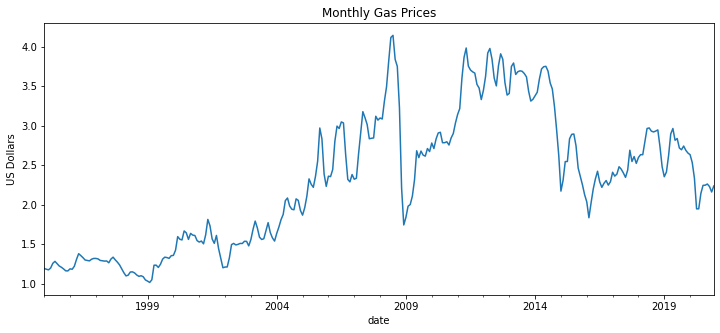

In [12]:
title='Monthly Gas Prices'
ylabel='US Dollars'

ax = ts.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set_ylabel(ylabel);

The two major dips in the data, we have determined were due to the economy crash in 2008, and the overproduction of crude oil from Saudi Arabia in 2014.

In order to proceed, because the data is clearly not stationary, we will attempt to stationarize it.

In [13]:
def decompose(timeseries):
    """
    This function takes a timeseries
    and performs a seasonal decompose
    """
    result = seasonal_decompose(timeseries, model='add')
    result.plot();

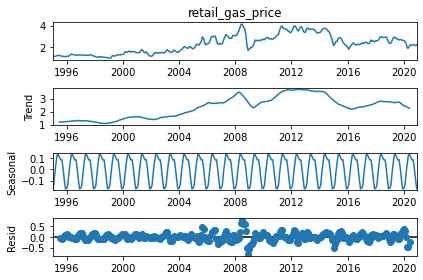

In [14]:
decompose(ts)

It looks like we have some seasonality in the data. Our research shows that this could be because of the rising demand for oil in the summer months as people do more driving.

In [15]:
def stationarity_test(timeseries):
    """
    This function takes a timeseries and creates
    a graph with the rolling mean and standard deviation, 
    and additionally calculates the Augmented Dickey Fuller 
    test's p-value.
    """
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Month')
    plt.ylabel('Gas Price in US Dollars')
    plt.title('Monthly Distribution of Gas Prices')
    plt.show()

    print(f'Augmented Dickey Fuller p-value: {adfuller(timeseries)[1]}')

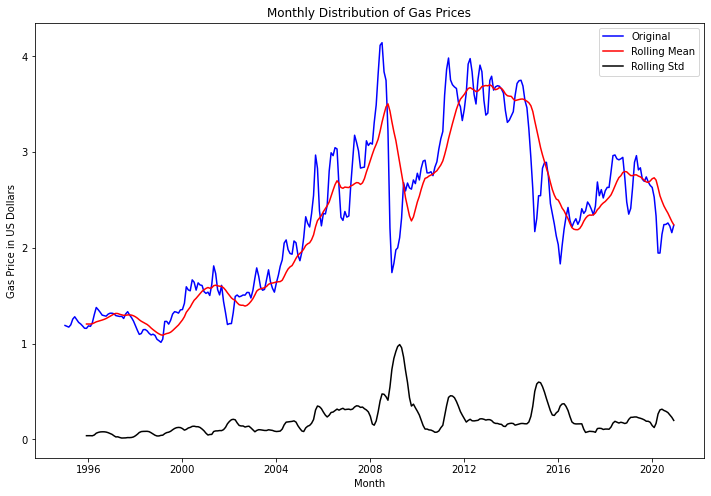

Augmented Dickey Fuller p-value: 0.448167594922904


In [16]:
stationarity_test(ts)

This pvalue for the Augmented Dickey Fuller test tells us that our data is not stationary. We will now take a first difference to get a lower pvalue.

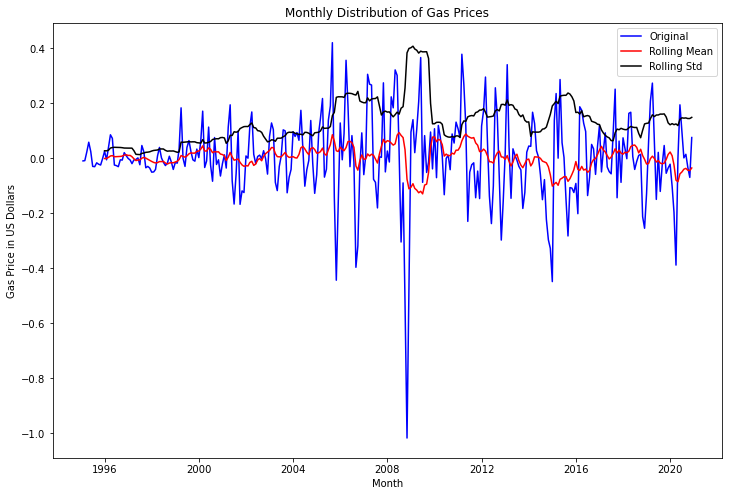

Augmented Dickey Fuller p-value: 1.614616710411381e-08


In [17]:
#first difference
ts_diff = ts.diff().dropna()

stationarity_test(ts_diff)

Now the p-value is much lower. It is under the threshold, so we can consider it stationarized.

# Model Preparation

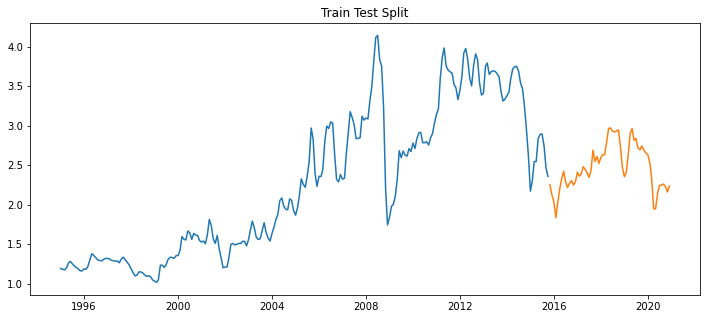

In [18]:
#splitting the data into train/test
cutoff = round(ts.shape[0]*0.8)


train = ts[:cutoff] #everything up to the cutoff
test = ts[cutoff:] #cutoff up

fig, ax = plt.subplots(figsize=(12,5))
plot_train = ax.plot(train)
plot_test = ax.plot(test)
ax.set_title('Train Test Split');

In [19]:
def acf_pcf(timeseries, lag):
    """
    This function takes in a timeseries and the desired lag,
    it outputs side by side ACF PACF graphs.
    """
    fig, axes = plt.subplots(1, 2, figsize=(17, 5))
    fig.suptitle('ACF & PACF')

    sm.graphics.tsa.plot_acf(timeseries.iloc[1:], lags=lag, ax=axes[0])

    sm.graphics.tsa.plot_pacf(timeseries.iloc[1:], lags=lag, ax=axes[1])
    plt.tight_layout()

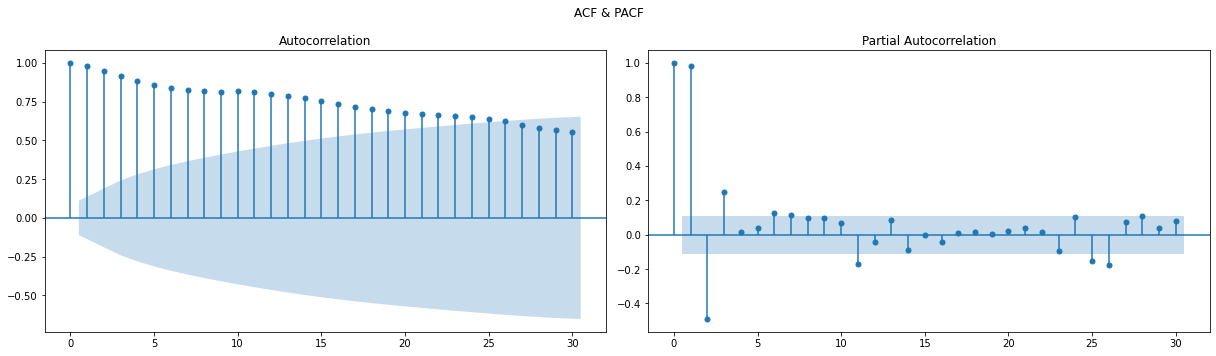

In [20]:
acf_pcf(ts, 30)

The ACF graph demonstrations positive autocorrelation. This tells use to add a first difference.

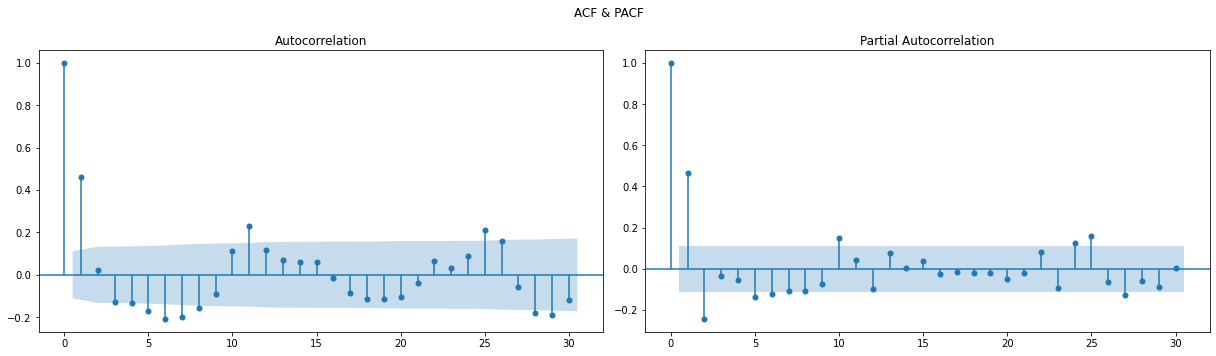

In [21]:
acf_pcf(ts.diff().dropna(), 30)

For our model, the PAC and ACF results suggest an AR of 2 and an MA of 1.

## ARIMA Model

In [22]:
#importing ARIMA
from statsmodels.tsa.arima.model import ARIMA

ar = ARIMA(train, order=(2, 1, 1)).fit()
train_yhat_ar = ar.predict(typ='levels')
train_yhat_ar[:5]

1995-01-01    0.000000
1995-02-01    1.190000
1995-03-01    1.176693
1995-04-01    1.170168
1995-05-01    1.212214
Freq: MS, Name: predicted_mean, dtype: float64

In [23]:
#r2 value
np.sqrt(mean_squared_error(train, train_yhat_ar))

0.1497206692160478

In [24]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       retail_gas_price   No. Observations:                  250
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 155.018
Date:                Mon, 19 Apr 2021   AIC                           -302.036
Time:                        18:06:37   BIC                           -287.966
Sample:                    01-01-1995   HQIC                          -296.372
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2884      0.065     19.751      0.000       1.161       1.416
ar.L2         -0.5362      0.044    -12.133      0.000      -0.623      -0.450
ma.L1         -0.7842      0.072    -10.820      0.000      -0.926      -0.642
sigma2         0.0168      0.001     15.027      0.000       0.015       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               262.83
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               5.08   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
def predictions_graph(predictions, data):
    """
    This function takes in the predictions and data (train or test) outputs
    2 graphs, 1 of the predictions, and 1 of the predictions zoomed in.
    """
    fig, axes = plt.subplots(1, 2, figsize=(17, 5))
    
    axes[0].plot(predictions)
    axes[0].plot(data)
    axes[0].set_title('Predictions')
    
    axes[1].plot(predictions[-50:])
    axes[1].plot(data[-50:])
    axes[1].set_title('Zoomed In Predictions')

    plt.tight_layout()

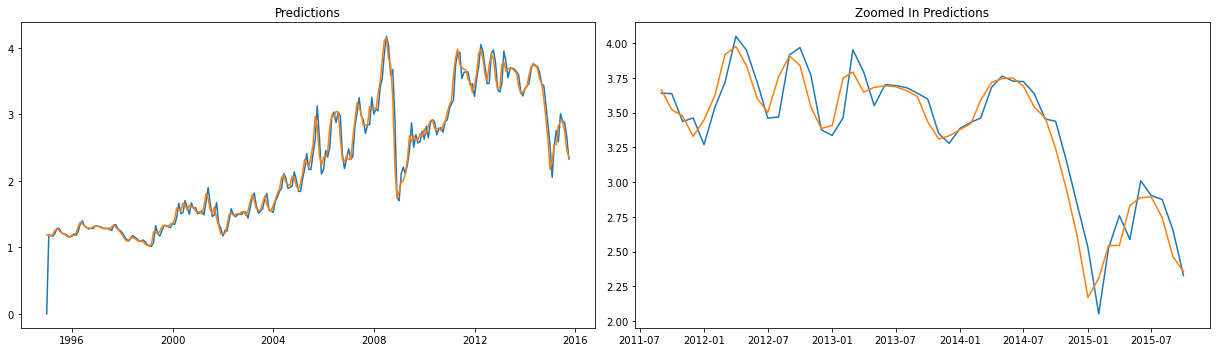

In [39]:
predictions_graph(train_yhat_ar, train)

In [40]:
test.head()

date
2015-11-01    2.249
2015-12-01    2.125
2016-01-01    2.034
2016-02-01    1.833
2016-03-01    2.021
Name: retail_gas_price, dtype: float64

In [41]:
test_yhat_ar = ar.predict(start = test.index[0],end = test.index[-1],typ='levels')

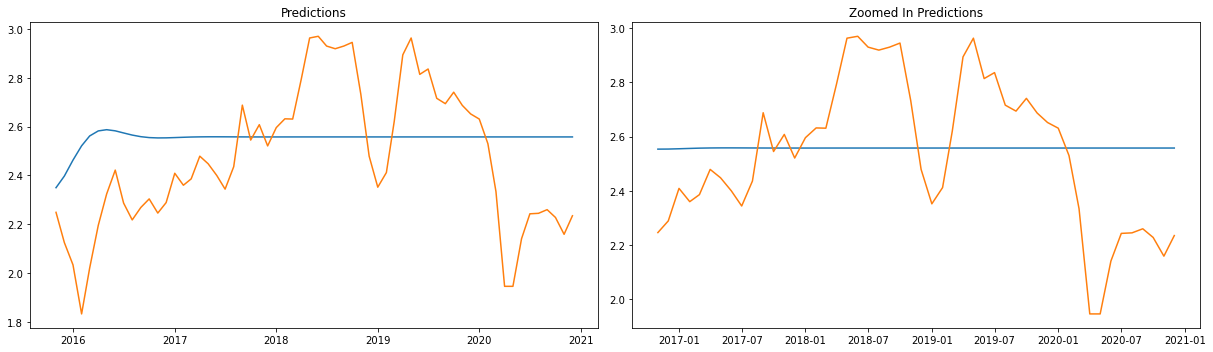

In [42]:
predictions_graph(test_yhat_ar, test)

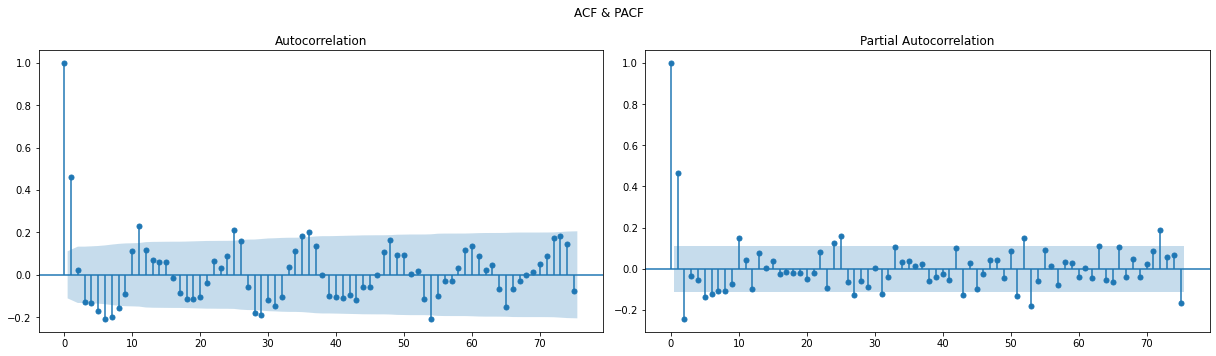

In [64]:
acf_pcf(ts.diff().dropna(),75)

When we expanded the lag count, we noticed a seasonal pattern. We are going to address it with a different model, SARIMA.

# Sarima Model

In [58]:
# auto_arima(oil_prices['retail_gas_price'], seasonal=True,m=12).summary()

In [51]:
#importing SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sr =SARIMAX(train,
                  order=(2, 1, 1),
                  seasonal_order=(2, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

train_yhat_sr = sr.predict(typ='levels')
train_yhat_sr[:5]

1995-01-01    0.000000
1995-02-01    1.385946
1995-03-01    1.143015
1995-04-01    1.142511
1995-05-01    1.199741
Freq: MS, Name: predicted_mean, dtype: float64

In [52]:
#r2 value
np.sqrt(mean_squared_error(train, train_yhat_sr))

0.15371995347016898

In [53]:
sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   retail_gas_price   No. Observations:                  250
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 116.855
Date:                            Mon, 19 Apr 2021   AIC                           -219.709
Time:                                    18:43:05   BIC                           -196.246
Sample:                                01-01-1995   HQIC                          -210.225
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4940      0.307      1.609      0.108      -0.108       1.096
ar.L2         -0.2199      0.146     -1.502      0.133      -0.507       0.067
ma.L1          0.0410      0.292      0.140      0.888      -0.532       0.614
ar.S.L12      -0.2575      0.075     -3.418      0.001      -0.405      -0.110
ar.S.L24      -0.1835      0.092     -2.005      0.045      -0.363      -0.004
ma.S.L12      -0.8291      0.069    -12.024      0.000      -0.964      -0.694
sigma2         0.0182      0.001     12.955      0.000       0.015       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               111.55
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

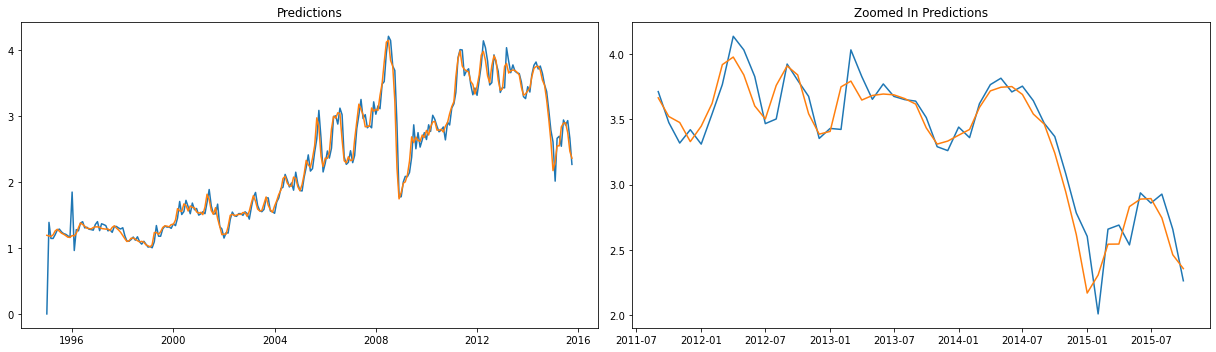

In [54]:
predictions_graph(train_yhat_sr, train)

In [55]:
test.head()

date
2015-11-01    2.249
2015-12-01    2.125
2016-01-01    2.034
2016-02-01    1.833
2016-03-01    2.021
Name: retail_gas_price, dtype: float64

In [56]:
test_yhat_sr = sr.predict(start = test.index[0],end = test.index[-1],typ='levels')

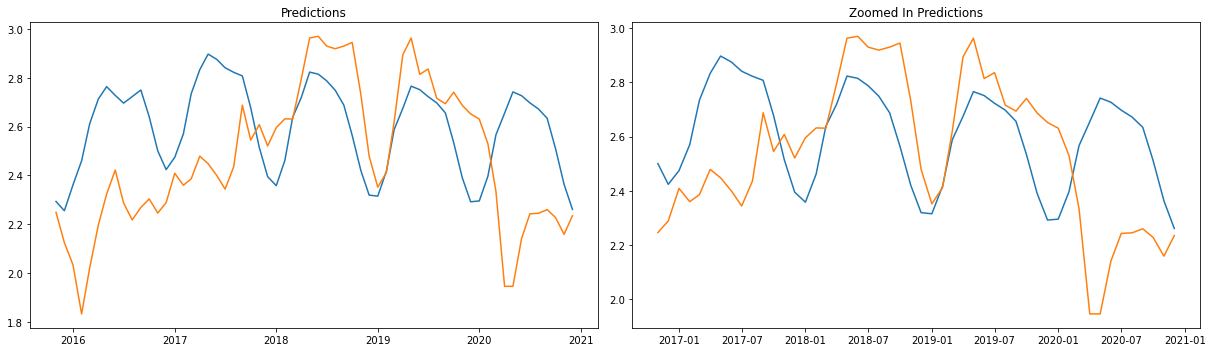

In [57]:
predictions_graph(test_yhat_sr, test)